In [1]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

DATA_FILE = DATA_DIR / "motley-fool-data.pkl"

DATA_FILE

WindowsPath('C:/Users/ssmyt/earnings-call-nlp/data/motley-fool-data.pkl')

In [3]:
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)
type(data)

pandas.core.frame.DataFrame

In [4]:
df = data.copy()
df.shape

(18755, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18755 entries, 0 to 18754
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        18755 non-null  object
 1   exchange    18755 non-null  object
 2   q           18755 non-null  object
 3   ticker      18755 non-null  object
 4   transcript  18755 non-null  object
dtypes: object(5)
memory usage: 732.7+ KB


In [6]:
#Check to see how dates are formatted 
df["date"].head()

0    Aug 27, 2020, 9:00 p.m. ET
1    Jul 30, 2020, 4:30 p.m. ET
2    Oct 23, 2019, 5:00 p.m. ET
3    Nov 6, 2019, 12:00 p.m. ET
4     Aug 7, 2019, 8:30 a.m. ET
Name: date, dtype: object

In [7]:
#See how many dates cant be  coerced into datetime object
import warnings

# Use this magic command at the top of your specific code cell
# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Perform the calculation and assign the result to the variable
invalid_count = pd.to_datetime(df['date'], errors='coerce').isna().sum()
invalid_count

C:\Users\ssmyt\AppData\Local\Temp\ipykernel_19708\3713727637.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  invalid_count = pd.to_datetime(df['date'], errors='coerce').isna().sum()


380

# Clean dates 

In [8]:
#Method to clean dates
import pandas as pd
import re
import ast

def parse_clean_date(x):
    
    date_str = None
    
    if isinstance(x, list):
        for item in x:
            if isinstance(item, str) and "ET" in item:
                date_str = item
                break
    
    elif isinstance(x, str):
        # Stringified list?
        if x.startswith("[") and x.endswith("]"):
            try:
                items = ast.literal_eval(x)
                for item in items:
                    if isinstance(item, str) and "ET" in item:
                        date_str = item
                        break
            except:
                return pd.NaT
        else:
            date_str = x
    else:
        return pd.NaT

    if date_str is None:
        return pd.NaT

    date_str = re.sub(r"\sET$", "", date_str)        # remove ET
    date_str = date_str.replace("a.m.", "AM").replace("p.m.", "PM")  # normalize AM/PM
    date_str = date_str.replace('.', '')             # remove dots in month abbreviation

    try:
        return pd.to_datetime(date_str)
    except:
        return pd.NaT



In [9]:
# data types in date column
df['date'].apply(type).value_counts()


date
<class 'str'>     18376
<class 'list'>      379
Name: count, dtype: int64

In [10]:
# reduces missing to 5 dates
df["call_datetime"] = df["date"].apply(parse_clean_date)
df['call_datetime'].isna().sum()

C:\Users\ssmyt\AppData\Local\Temp\ipykernel_19708\1948113217.py:40: UserWarning: Parsing dates in Sept %d, %Y, %m:%M %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


5

In [11]:
#drop the 5 invalid datetime rows
df = df.dropna(subset=['call_datetime']).copy()

In [12]:
df["call_datetime"].isna().sum() # no bad dates remaining

0

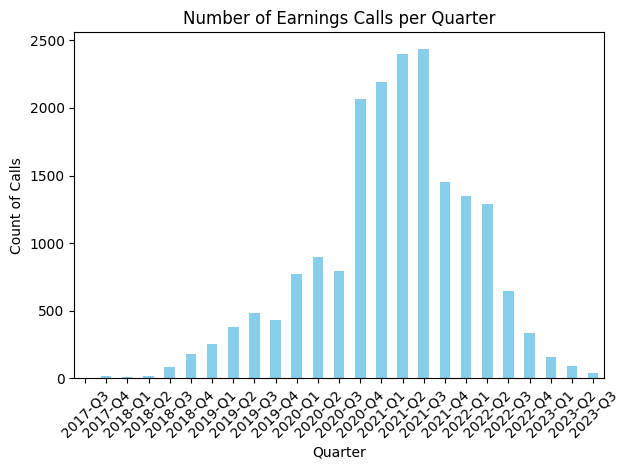

In [13]:
# data seems to be primarily from 2020 -2021 
quarter_counts = df['q'].value_counts()
quarter_counts = quarter_counts.sort_index()

quarter_counts.plot(kind='bar', color='skyblue')

plt.title('Number of Earnings Calls per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count of Calls')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

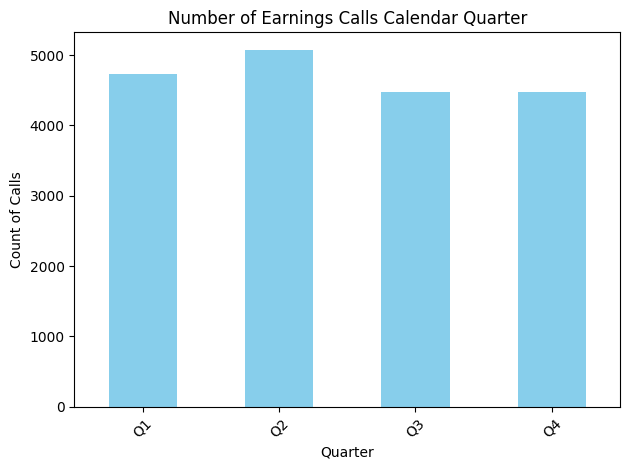

In [14]:
# relatively balanced throughout year
df['quarter_only'] = df['q'].str.split('-').str[1]
qonly_counts = df['quarter_only'].value_counts()
qonly_counts = qonly_counts.sort_index()

qonly_counts.plot(kind='bar', color='skyblue')

plt.title('Number of Earnings Calls Calendar Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count of Calls')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()



# Clean transcript

In [16]:
#Inspect tbe transcript column
df.loc[0, "transcript"][:1000]

"Prepared Remarks:\nOperator\nGood day, and welcome to the Bilibili 2020 Second Quarter Earnings Conference Call. Today's conference is being recorded.\nAt this time, I would like to turn the conference over to Juliet Yang, Senior Director of Investor Relations. Please go ahead.\nJuliet Yang -- Senior Director of Investor Relations\nThank you, operator.\nPlease note the discussion today will contain forward-looking statements relating to the Company's future performance, and are intended to qualify for the Safe Harbor from liability, as established by the US Private Securities Litigation Reform Act. Such statements are not guarantees of future performance and are subject to certain risks and uncertainties, assumptions and other factors. Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion. A general discussion of the risk factors that could affect Bilibili's business an

In [17]:
def clean_transcript_basic(text):
    if not isinstance(text, str):
        return ""

    # Fix common encoding artifacts
    text = text.replace("\xa0", " ")

    # Normalize Windows/Mac newlines to \n
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # Collapse multiple blank lines into a single newline
    text = re.sub(r"\n{2,}", "\n", text)

    # Strip leading/trailing whitespace on each line
    lines = [line.strip() for line in text.split("\n")]

    # Rejoin preserving line structure
    text = "\n".join(lines)

    return text


In [18]:
#samople only 500 rows for managability 
df_sample = df.sample(n=500, random_state=42).copy()
df_sample = df_sample.reset_index(drop=True)

In [19]:
df_sample['transcript_clean_basic'] = df_sample['transcript'].apply(clean_transcript_basic)

In [20]:
#remove boilerplate language that would dominitate summarization prepared remarks etc
def clean_transcript_nlp(text):
    lines = text.split("\n")
    cleaned_lines = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue  # skip empty lines

        # Remove boilerplate / legal / operator lines
        if re.search(r"^Prepared Remarks|^Operator|forward-looking statements|Safe Harbor|\[Operator instructions\]", line, re.I):
            continue

        # Keep speaker headers like "Name -- Title"
        
        cleaned_lines.append(line)

    # Join lines with single space or newline
    cleaned_text = " ".join(cleaned_lines)
    
    
    cleaned_text = re.sub(r"\s+", " ", cleaned_text)
    
    return cleaned_text


In [21]:
df_sample["transcript_nlp"] = df_sample["transcript"].apply(clean_transcript_nlp)

In [22]:
print(df_sample.iloc[0]["transcript_nlp"][:300])

Good afternoon, ladies and gentlemen. My name is Brent, and I will be your conference operator today. I would like to welcome everyone to the Gap Inc. third quarter 2022 earnings conference call. Cammeron McLaughlin -- Head of Investor Relations Bobby Martin -- Chief Executive Officer Thank you, Cam


In [23]:
print(df_sample.iloc[0]["transcript"][:300])

Prepared Remarks:
Operator
Good afternoon, ladies and gentlemen. My name is Brent, and I will be your conference operator today. I would like to welcome everyone to the Gap Inc. third quarter 2022 earnings conference call.
[Operator instructions] I would now like to introduce your host, Cammeron McL


In [24]:
(df_sample['transcript_clean_basic'].str.len() - df_sample['transcript_nlp'].str.len()).describe()

count     500.000000
mean     1392.974000
std       585.312682
min        28.000000
25%      1013.000000
50%      1336.500000
75%      1715.750000
max      4151.000000
dtype: float64

In [30]:
df_sample.iloc[(df_sample['transcript_clean_basic'].str.len() - df_sample['transcript_nlp'].str.len()).idxmax()][['transcript_clean_basic','transcript_nlp']]

transcript_clean_basic    Prepared Remarks:\nOperator\nGood day and welc...
transcript_nlp            I would now like to turn the call over to Beth...
Name: 476, dtype: object

In [31]:
df_sample.iloc[(df_sample['transcript_clean_basic'].str.len() - df_sample['transcript_nlp'].str.len()).idxmin()][['transcript_clean_basic','transcript_nlp']]

transcript_clean_basic    Prepared Remarks:\nCarla Dodsworth Albano Mill...
transcript_nlp            Carla Dodsworth Albano Miller -- Investor Rela...
Name: 143, dtype: object

In [115]:
import re

def split_qanda_full_multi(text):
    """
    Splits transcript into prepared remarks and Q&A by finding
    the first occurrence of any Q&A marker in the full text.
    """
    # List of Q&A marker patterns
    qna_markers = [
        r"Question-and-Answer Session",
        r"Questions and Answers",
        r"Questions & Answers",
        r"\bQ&A\b",
        r"Analyst Questions"
    ]
    
    # Combine into a single regex pattern (ignore case)
    pattern = re.compile("|".join(qna_markers), re.I)
    
    # Search for the first match in the full text
    match = pattern.search(text)
    
    if not match:
        # If no marker found, all text is prepared remarks
        return {"prepared_remarks": text.strip(), "qna": ""}
    
    # Split at the start of the matched marker
    idx = match.start()
    return {
        "prepared_remarks": text[:idx].strip(),
        "qna": text[idx:].strip()
    }


In [116]:
text = df_sample.loc[0, "transcript_nlp"]


In [93]:
len(text)

56152

In [109]:
for i,word in enumerate(text.split(' ')):
    if word == '&':
        print(i)

3603


In [110]:
def split_qanda_simple(text):
    """
    Splits transcript into prepared remarks and Q&A at the exact line
    'Questions & Answers:'. Returns all in prepared_remarks if not found.
    """
    lines = text.split("\n")
    
    split_index = None
    for i, line in enumerate(lines):
        line_clean = line.strip()
        if line_clean == "Questions & Answers:":
            split_index = i
            break
    
    if split_index is None:
        return {
            "prepared_remarks": text,
            "qna": ""
        }
    
    return {
        "prepared_remarks": "\n".join(lines[:split_index]),
        "qna": "\n".join(lines[split_index:])
    }

# Example usage
sections = split_qanda_simple(text)
prepared_remarks = sections["prepared_remarks"]
qna = sections["qna"]

print("Prepared length:", len(prepared_remarks))
print("Q&A length:", len(qna))

Prepared length: 56152
Q&A length: 0


In [111]:
text

"Good afternoon, ladies and gentlemen. My name is Brent, and I will be your conference operator today. I would like to welcome everyone to the Gap Inc. third quarter 2022 earnings conference call. Cammeron McLaughlin -- Head of Investor Relations Bobby Martin -- Chief Executive Officer Thank you, Cammeron, and good afternoon, everyone. After four months as interim president and CEO, I have even deeper conviction that we have a portfolio of iconic brands that our customers love, an increased confidence in our platform to drive leverage and economies of scale and belief in this team's ability to deliver. We know where we've gotten things wrong, and the team and I are at work to correct them. As I told you last quarter, we can and we should win in any environment and the management team and I continue to hold the company accountable to deliver on that. We've taken action to optimize profitability and cash flow while rebalancing and reducing inventory to drive near- and long-term improveme

In [118]:
# Apply the split function to the dataframe
split_sections = df_sample['transcript_clean_basic'].apply(split_qanda_full_multi)

# Extract prepared_remarks and qna into separate columns
df_sample['prepared_remarks_nlp'] = split_sections.apply(lambda x: x['prepared_remarks'])
df_sample['qna_nlp'] = split_sections.apply(lambda x: x['qna'])

# Quick check: print lengths to ensure splits happened
df_sample[['prepared_remarks_nlp', 'qna_nlp']].head()

# Optional: verify that every row has a split
df_sample['prepared_len'] = df_sample['prepared_remarks_nlp'].str.len()
df_sample['qna_len'] = df_sample['qna_nlp'].str.len()

print(df_sample[['prepared_len', 'qna_len']].describe())


       prepared_len       qna_len
count     500.00000    500.000000
mean    12366.68800  34931.238000
std     10382.28152  15624.949666
min       123.00000      0.000000
25%       833.00000  24271.750000
50%     13799.00000  33263.000000
75%     20263.75000  43938.500000
max     51642.00000  82412.000000


In [119]:
# Find rows with no Q&A
no_qna = df_sample[df_sample['qna_len'] == 0]

# Inspect
no_qna[['ticker', 'prepared_remarks_nlp', 'qna_nlp']]


,ticker,prepared_remarks_nlp,qna_nlp
319,NFLX,Prepared Remarks:\nSpencer Wang\nGood afternoo...,


In [121]:
df_sample.iloc[319]['prepared_remarks_nlp']

'Prepared Remarks:\nSpencer Wang\nGood afternoon, and welcome to the Netflix Q4 2022 earnings interview. I\'m Spencer Wang, VP of finance, IR and corporate development. Joining me today are Executive Chairman Reed Hastings; Co-CEOs Ted Sarandos and Greg Peters; and CFO Spence Neumann. Our interviewer this quarter is Jessica Reif Ehrlich from Bank of America.\nAs a reminder, we\'ll be making forward-looking statements, and actual results may vary. With that, Jessica, over to you for your first question.\nJessica Ehrlich -- Bank of America Merrill Lynch -- Analyst\nThank you, and thank you so much for having me today. So, Reed, the big announcement about the management changes. Could you give us some more color on the process and how you came to this decision?\nReed Hastings -- Co-Chief Executive Officer\nYou know, Jessica, it feels like yesterday was our IPO. We were covered in red envelopes. We IPO-ed at about $1. Hopefully, some of you have held the stock, the full 21 years.\nAnd when